In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import pgeocode # import pgeocode
import folium # map rendering library
import requests
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
pd.set_option('display.max_rows', None)

In [2]:
subways = pd.read_excel("C:/Users/Vicente/Desktop/subways.xlsx")

# Add city, country = Santiago, Chile to improve geolocator
subways['subway_station'] = subways['subway_station'] + ', Santiago, Chile' 

# Remove announced but not operating subway stations
subways = subways[~subways['opening_date'].isnull()].reset_index(drop = True)

# Save "Linea" as a string
subways.astype({'Linea': 'str'}).dtypes

subway_station    object
opening_date      object
Linea             object
dtype: object

In [3]:
def coordinates(location):
    loc = geolocator.geocode(location)
    
    if type(loc.latitude) == float: 
        return loc.latitude, loc.longitude
    
    else:
        loc_extended = 'Metro ' + location 
        loc2 = geolocator.geocode(loc_extended)
        
        if type(loc2.latitude) == float:
            return loc2.latitude, loc2.longitude 
        else:
            return '', ''
        

In [4]:
geolocator = Nominatim(user_agent="geo", timeout = None)
for index, subway in enumerate(subways['subway_station']): 
    coord = coordinates(subway)
    subways.loc[index,'latitude'] = coord[0]
    subways.loc[index,'longitude'] = coord[1]

In [5]:
def santiago_map(stations):
    
    santiago_latitude = -33.4489
    santiago_longitude = -70.6693
    
    map_santiago = folium.Map(location=[santiago_latitude, santiago_longitude], zoom_start=12)
    
    # Add markers to map

    for lat, lng, subway in zip(stations['latitude'], stations['longitude'], stations['subway_station']):
        label = '{}'.format(subway)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7, 
            parse_html=False).add_to(map_santiago) 
        
    return map_santiago

In [6]:
subway_line1 = subways[subways['Linea'] == 1]
santiago_map(subway_line1)

## Connecting to Foursquare

In [7]:
CLIENT_ID = 'YXTKAWRUBA1SNMTSJ01ETW2Z2OADLUIRNVMV1TX0UAZO0IC5' # your Foursquare ID
CLIENT_SECRET = 'CS03U4LZDQA1P2BPERQHLQRARG34TDUCX5SAKRKIAL5TTWZI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YXTKAWRUBA1SNMTSJ01ETW2Z2OADLUIRNVMV1TX0UAZO0IC5
CLIENT_SECRET:CS03U4LZDQA1P2BPERQHLQRARG34TDUCX5SAKRKIAL5TTWZI


In [8]:
# Function to analyze neighborhoods

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Metro Station', 
                  'Metro Station Latitude', 
                  'Metro Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
LIMIT = 100
radius = 500

map_venues = getNearbyVenues(names=subway_line1['subway_station'],
                                   latitudes=subway_line1['latitude'],
                                   longitudes=subway_line1['longitude']
                                 )

San Pablo, Santiago, Chile
Neptuno, Santiago, Chile
Pajaritos, Santiago, Chile
Las Rejas, Santiago, Chile
Ecuador, Santiago, Chile
San Alberto Hurtado, Santiago, Chile
Universidad de Santiago, Santiago, Chile
Estación Central, Santiago, Chile
Unión Latinoamericana, Santiago, Chile
República, Santiago, Chile
Los Héroes, Santiago, Chile
La Moneda, Santiago, Chile
Universidad de Chile, Santiago, Chile
Santa Lucía, Santiago, Chile
Universidad Católica, Santiago, Chile
Baquedano, Santiago, Chile
Salvador, Santiago, Chile
Manuel Montt, Santiago, Chile
Pedro de Valdivia, Santiago, Chile
Los Leones, Santiago, Chile
Tobalaba, Santiago, Chile
El Golf, Santiago, Chile
Alcántara, Santiago, Chile
Escuela Militar, Santiago, Chile
Manquehue, Santiago, Chile
Hernando de Magallanes, Santiago, Chile
Los Dominicos, Santiago, Chile


In [13]:
#Drop venue category equal to Metro Station
df_venues = map_venues[map_venues['Venue Category'] != 'Metro Station']

## Analyze venues 

In [14]:
# Dummies 
subway_dummy = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

#Add Metro stations to the first column
subway_dummy['subway_station'] = df_venues['Metro Station'] 
fixed_columns = [subway_dummy.columns[-1]] + list(subway_dummy.columns[:-1])
subway_dummy = subway_dummy[fixed_columns]

In [15]:
subway_dummy.head()

,subway_station,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Toy / Game Store,Track Stadium,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"San Pablo, Santiago, Chile",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"San Pablo, Santiago, Chile",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"San Pablo, Santiago, Chile",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"San Pablo, Santiago, Chile",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,"San Pablo, Santiago, Chile",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Group by Metro Stations
metro_grouped = subway_dummy.groupby('subway_station').mean().reset_index()
metro_grouped.head()

,subway_station,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Toy / Game Store,Track Stadium,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Alcántara, Santiago, Chile",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,...,0.0,0.010000,0.01,0.0,0.0,0.00,0.00,0.01,0.0,0.01
1,"Baquedano, Santiago, Chile",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.02,0.03,...,0.0,0.000000,0.00,0.0,0.0,0.00,0.02,0.00,0.0,0.01
2,"Ecuador, Santiago, Chile",0.0,0.0,0.0,0.0,0.0,0.0,0.025641,0.00,0.00,...,0.0,0.000000,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00
3,"El Golf, Santiago, Chile",0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.00,0.00,...,0.0,0.000000,0.01,0.0,0.0,0.01,0.00,0.01,0.0,0.01
4,"Escuela Militar, Santiago, Chile",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,...,0.0,0.012048,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00


In [17]:
# Venues per Metro Station

num_top_venues = 5

for subway in metro_grouped['subway_station']:
    print("----"+subway+"----")
    temp = metro_grouped[metro_grouped['subway_station'] == subway].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alcántara, Santiago, Chile----
         venue  freq
0  Coffee Shop  0.12
1       Bakery  0.07
2         Café  0.06
3        Hotel  0.05
4        Plaza  0.04


----Baquedano, Santiago, Chile----
                 venue  freq
0                Hotel  0.08
1           Restaurant  0.07
2               Hostel  0.05
3          Coffee Shop  0.05
4  Peruvian Restaurant  0.05


----Ecuador, Santiago, Chile----
                  venue  freq
0      Sushi Restaurant  0.10
1           Bus Station  0.08
2                   Gym  0.05
3  Fast Food Restaurant  0.05
4                Bakery  0.05


----El Golf, Santiago, Chile----
            venue  freq
0           Hotel  0.11
1     Coffee Shop  0.08
2            Café  0.06
3          Bakery  0.04
4  Cosmetics Shop  0.03


----Escuela Militar, Santiago, Chile----
         venue  freq
0  Coffee Shop  0.12
1         Café  0.08
2       Bakery  0.06
3   Restaurant  0.05
4        Plaza  0.05


----Estación Central, Santiago, Chile----
              venue  

In [18]:
# Function for common venues

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['subway_station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
stations_venues_sorted = pd.DataFrame(columns=columns)
stations_venues_sorted['subway_station'] = metro_grouped['subway_station']

for ind in np.arange(metro_grouped.shape[0]):
    stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(metro_grouped.iloc[ind, :], num_top_venues)

pd.set_option('display.max_rows', None)    
stations_venues_sorted

,subway_station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Alcántara, Santiago, Chile",Coffee Shop,Bakery,Café,Hotel,Plaza,Sandwich Place,Restaurant,Deli / Bodega,Cosmetics Shop,Creperie
1,"Baquedano, Santiago, Chile",Hotel,Restaurant,Peruvian Restaurant,Hostel,Coffee Shop,Park,Bar,Art Museum,Theater,Japanese Restaurant
2,"Ecuador, Santiago, Chile",Sushi Restaurant,Bus Station,Fast Food Restaurant,Gym,Pizza Place,Bakery,Burger Joint,Pharmacy,Chinese Restaurant,Restaurant
3,"El Golf, Santiago, Chile",Hotel,Coffee Shop,Café,Bakery,Restaurant,Plaza,Italian Restaurant,Clothing Store,Cosmetics Shop,Gym
4,"Escuela Militar, Santiago, Chile",Coffee Shop,Café,Bakery,Restaurant,Plaza,Dessert Shop,Fast Food Restaurant,Park,Pharmacy,Board Shop
5,"Estación Central, Santiago, Chile",Pharmacy,Plaza,Bus Station,Bakery,Chinese Restaurant,Asian Restaurant,Gym,Soccer Stadium,Soccer Field,Fast Food Restaurant
6,"Hernando de Magallanes, Santiago, Chile",Sushi Restaurant,Plaza,Restaurant,Bakery,Sandwich Place,Electronics Store,Chinese Restaurant,Pizza Place,Café,Coffee Shop
7,"La Moneda, Santiago, Chile",Coffee Shop,Café,Bookstore,Pizza Place,Sandwich Place,Park,Vegetarian / Vegan Restaurant,Restaurant,Theater,Bakery
8,"Las Rejas, Santiago, Chile",Pharmacy,Bakery,Fast Food Restaurant,Asian Restaurant,Gym,Bus Station,Spa,Soccer Stadium,Soccer Field,Food Truck
9,"Los Dominicos, Santiago, Chile",Restaurant,Plaza,Pharmacy,Sushi Restaurant,Arts & Crafts Store,Multiplex,Park,Japanese Restaurant,Grocery Store,Coffee Shop


## Cluster Metro Stations

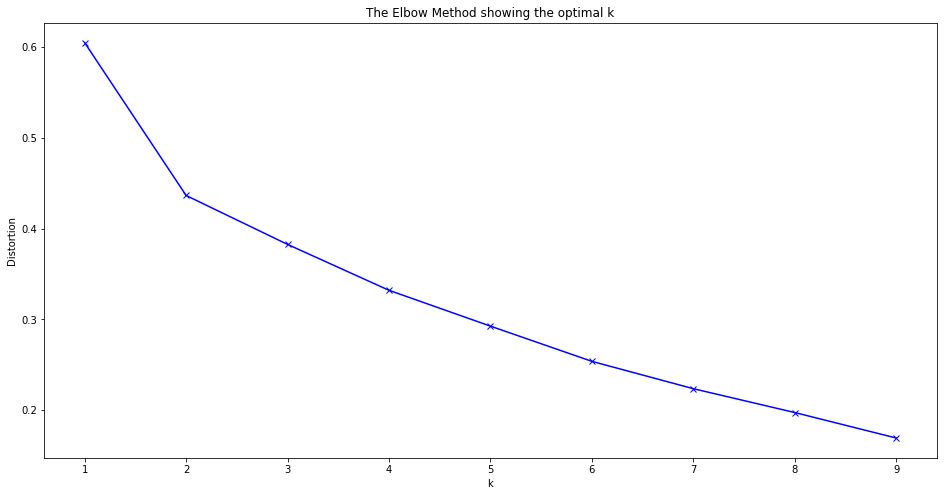

In [20]:
# Drop the metro name
metro_grouped_clustering = metro_grouped.drop('subway_station', 1)

distortions = []
list_clusters = range(1,10)
for clusters in list_clusters:
    kmeans = KMeans(n_clusters = clusters)
    kmeans.fit(metro_grouped_clustering)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(list_clusters, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [25]:
# Selecting 3 clusters
kclusters = 2
kmeans = KMeans(n_clusters = kclusters)
kmeans.fit(metro_grouped_clustering)

# add clustering labels
stations_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
    
# Merged df
metro_merged = subway_line1
metro_merged = metro_merged.join(stations_venues_sorted.set_index('subway_station'), on='subway_station')

In [26]:
metro_merged

,subway_station,opening_date,Linea,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"San Pablo, Santiago, Chile",15 de septiembre de 1975,1,-33.444305,-70.723176,1,Nightclub,Sushi Restaurant,Bakery,Farmers Market,Pharmacy,Convenience Store,Bus Station,Flea Market,Garden Center,Department Store
1,"Neptuno, Santiago, Chile",15 de septiembre de 1975,1,-33.451467,-70.722616,1,Bus Station,Sushi Restaurant,Farmers Market,Bakery,Nightclub,Pharmacy,Diner,Seafood Restaurant,Chinese Restaurant,Coffee Shop
2,"Pajaritos, Santiago, Chile",15 de septiembre de 1975,1,-33.457511,-70.715460,1,Pharmacy,Bus Station,Fast Food Restaurant,Chinese Restaurant,Bar,Bakery,South American Restaurant,Burger Joint,Playground,Bus Line
3,"Las Rejas, Santiago, Chile",15 de septiembre de 1975,1,-33.457580,-70.706756,1,Pharmacy,Bakery,Fast Food Restaurant,Asian Restaurant,Gym,Bus Station,Spa,Soccer Stadium,Soccer Field,Food Truck
4,"Ecuador, Santiago, Chile",15 de septiembre de 1975,1,-33.455976,-70.699716,1,Sushi Restaurant,Bus Station,Fast Food Restaurant,Gym,Pizza Place,Bakery,Burger Joint,Pharmacy,Chinese Restaurant,Restaurant
5,"San Alberto Hurtado, Santiago, Chile",15 de septiembre de 1975,1,-33.454216,-70.692276,1,Fast Food Restaurant,Pizza Place,Pharmacy,Bakery,Sandwich Place,Burger Joint,Snack Place,Hotel,Fried Chicken Joint,Sushi Restaurant
6,"Universidad de Santiago, Santiago, Chile",15 de septiembre de 1975,1,-33.452897,-70.686569,1,Pharmacy,Sandwich Place,Fast Food Restaurant,Pizza Place,Bakery,Burger Joint,Fried Chicken Joint,Hotel,Shopping Mall,Sushi Restaurant
7,"Estación Central, Santiago, Chile",15 de septiembre de 1975,1,-33.463658,-70.704966,1,Pharmacy,Plaza,Bus Station,Bakery,Chinese Restaurant,Asian Restaurant,Gym,Soccer Stadium,Soccer Field,Fast Food Restaurant
8,"Unión Latinoamericana, Santiago, Chile",15 de septiembre de 1975,1,-33.449401,-70.673349,0,Bar,Seafood Restaurant,Chinese Restaurant,Restaurant,Pizza Place,Martial Arts Dojo,Café,Shopping Mall,Asian Restaurant,South American Restaurant
9,"República, Santiago, Chile",15 de septiembre de 1975,1,-33.447721,-70.667142,0,Pizza Place,Bar,Chinese Restaurant,Restaurant,Sandwich Place,Martial Arts Dojo,Peruvian Restaurant,Asian Restaurant,Pub,Diner


In [27]:
#Create cluster map
santiago_latitude = -33.4489
santiago_longitude = -70.6693

map_clusters = folium.Map(location=[santiago_latitude, santiago_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(metro_merged['latitude'], metro_merged['longitude'], metro_merged['subway_station'], metro_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters